# Summary

This notebook contains the code necessary to recreate our analysis of the effects of genre and visual enhancements on the total gross income of a movie. 

#### 1. Imports & Data Read-In
#### 2. Cleaning
#### 2. Subsetting
#### 3. Analysis & Graphs
***

## Imports & Data Read-In

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from cleaning_scripts import *

%matplotlib inline
sns.set_style('darkgrid')

In [4]:
final_df = pd.read_csv('./data/final.csv')


## 2. Cleaning

Once all our tables were merged, we followed this process below to clean our data.

### Generating total_gross column

In [14]:
# make sure domestic & foreign gross are both float types
final_df.domestic_gross = pd.to_numeric(final_df.domestic_gross, errors='coerce')
final_df.foreign_gross = pd.to_numeric(final_df.foreign_gross, errors='coerce')

# replace any gross na values with 0.0 (assuming an na means not presented domestically/internationally)
final_df.domestic_gross.fillna(0.0, inplace=True)
final_df.foreign_gross.fillna(0.0, inplace=True)

# add total_gross column, express value in billions
final_df['total_gross'] = final_df.domestic_gross + final_df.foreign_gross
final_df.total_gross = final_df.total_gross / 1_000_000_000

## 3. Subsetting

In [37]:
# drop repated movie listings that result in the same total_gross (these are just repeat listings)
unique_titles = final_df.drop_duplicates(subset=['primary_title', 'total_gross'])

# performant_genres: An ordered listing of the top 10 genre labels with the highest total_gross 
performant_genres = unique_titles.groupby("genres").sum().sort_values('total_gross', ascending=False).iloc[0:10, -1:]

# top subgenres: a cimple count of occurances of subgenres within the top performant genres
#     process subgenres
subgenres = get_subgenres(performant_genres.reset_index().genres)
top_subgenres = subgenre_counter(subgenres, performant_genres.reset_index())
#     Create subgenres dataframe
top_subgenres_df = pd.DataFrame(top_subgenres.items())
top_subgenres_df.columns = ["Genre", "Count"]
top_subgenres_df = top_subgenres_df.sort_values('Count', ascending=False)

# visually_enhanced: subset of movies with visual enhancements (3d or IMAX), grouped by genres
visually_enhanced = final_df[final_df.attributes.isin(['3-D version', 'IMAX version'])].sort_values('total_gross', ascending=False).loc[:, ["primary_title","total_gross"]]
top_visually_enhanced = visually_enhanced.groupby('primary_title').sum().sort_values('total_gross', ascending=False).iloc[:10, -1:]

# special_attributes: final_df grouped by attributes and sorted by total gross
special_attributes = final_df.groupby('attributes').sum().sort_values('total_gross', ascending=False)[0:12]

# three_d: a dataframe containing only films that had a 3D version. 
    # subset final_df by 3D versions
three_d = final_df[final_df.attributes == '3-D version']
    # count the number of 3D films per 
three_d_per_year = three_d.groupby('year').size()
split_3d = three_d
three_d = three_d.groupby('year').sum()
three_d['films_per_year'] = three_d_per_year
three_d['gross_by_num_films'] = three_d.total_gross / three_d.films_per_year

# imax: a dataframe containing only films that had a IMAX version
imax = final_df[final_df.attributes == 'IMAX version']
imax = imax.groupby('primary_title').sum()

## 3. Analysis

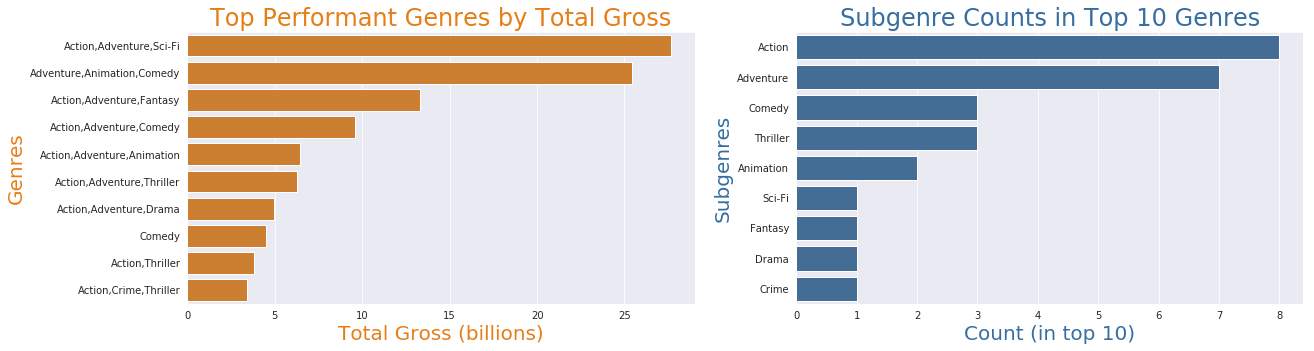

In [84]:
def plot_genre_comparison():
    """
    plots two charts:
    1. the top performant genres as listed in the dataset
    2. the subgenres extracted from those top 10 performant genres
    """
    plt.figure(figsize=(20, 5))
    
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)

    g1 = sns.barplot(data=performant_genres, y=performant_genres.index, x='total_gross', orient='h', ax=ax1, color="#E67E17")
    g1.set_title("Top Performant Genres by Total Gross", fontsize=24, color="#E67E17")
    g1.set_xlabel("Total Gross (billions)", fontsize=20, color="#E67E17")
    g1.set_ylabel('Genres', fontsize=20, color="#E67E17")
        
    g2 = sns.barplot(data=top_subgenres_df, x="Count", y='Genre', ax=ax2, color="#366DA2")
    g2.set_title("Subgenre Counts in Top 10 Genres", fontsize=24, color="#366DA2")
    g2.set_xlabel("Count (in top 10)", fontsize=20,color="#366DA2")
    g2.set_ylabel("Subgenres", fontsize=20, color="#366DA2")
    
    plt.subplots_adjust(wspace=0.2)
    plt.show()
    
plot_genre_comparison()

#### Analysis: 

Examination of the subgenres in the top 10 performant genres reveals the high yieled of action and adventure films. We can see  clearly with this these that both action and adeventure subgenres appear more than double the amount of times in the genre listings of the top performant genres.  

Our recommendation is that MS should direct its resources towards action and adventure movies to maximize profits.  

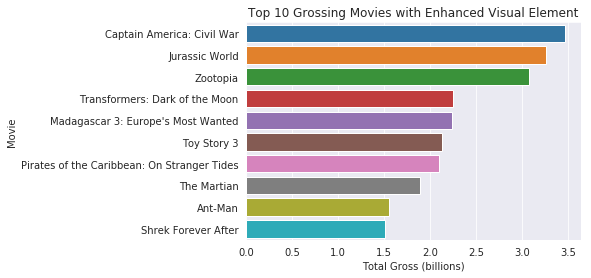

In [39]:
def plot_top_visually_enhanced_movies():
    """
    Shows the top 10 movies with some visually enhanced element (3D, IMAX) 
    ordered by total_gross revenue
    """
    sns.barplot(data=top_visually_enhanced, x='total_gross', y=top_visually_enhanced.index)
    plt.ylabel("Movie")
    plt.xlabel("Total Gross (billions)")
    plt.title("Top 10 Grossing Movies with Enhanced Visual Element")

plot_top_visually_enhanced_movies()

#### Analysis: 

We believe it is wise for Microsoft to use its existing line of media hardware to help carve a distinguishable path in this crowded product landscape.  

The chart above shows to gross income in billions of the top 10 highest grossing movies that had some visual enhancement (3D or IMAX versions). It is our suggestion that Microsoft use these films as models for further study to create similar productions that could also take advantage of their media technology. 
***

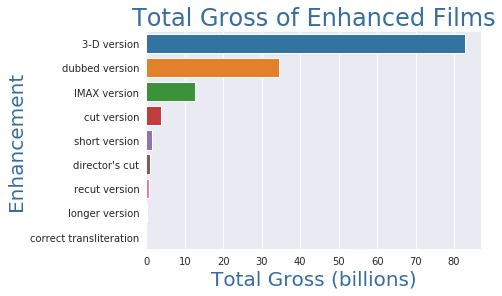

In [104]:
enhanced_attributes = final_df[final_df.attributes.str.contains("title|alt|promo")==False]

enhanced_attributes = enhanced_attributes.groupby('attributes').sum().sort_values('total_gross', ascending=False)
def plot_enhanced_attributes():
    """
    plots total gross revenue of films grouped by their attribute enhancements 
    """
    sns.barplot(data=enhanced_attributes, x='total_gross', y=enhanced_attributes.index)
    plt.xticks(rotation=0.5)
    plt.title("Total Gross of Enhanced Films", fontsize=24, color="#366DA2")
    plt.xlabel("Total Gross (billions)", fontsize=20, color="#366DA2")
    plt.ylabel("Enhancement", fontsize=20, color="#366DA2")
    plt.show()

plot_enhanced_attributes()

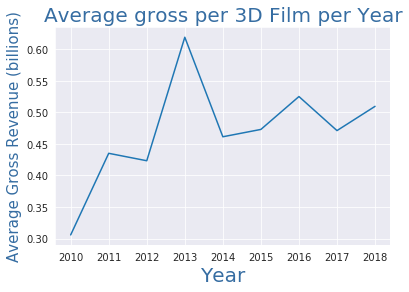

In [92]:
def plot_3d_trend():
    """
    Plots the focus on 3D films over an 8 year period from 2010-2018 
    """
    sns.lineplot(data=three_d.reset_index(), x='year', y='gross_by_num_films')
    plt.title("Average gross per 3D Film per Year", fontsize=20, color="#366DA2")
    plt.xlabel("Year", fontsize=20, color="#366DA2")
    plt.ylabel("Average Gross Revenue (billions)", fontsize=15, color="#366DA2")
    plt.show()
    
plot_3d_trend()

#### Analysis: 

(2nd graph)

Besides an anomalous spike in generated revenue in 2013, 3D films have experience a significant rise in gross profits since 2010, and have been holding relatively steady for the last 4 years. Given this trend and perceived staying power, the recommendation holds that Microsoft look into ways to use their proprietary technology to visually enhance their productions. 
***

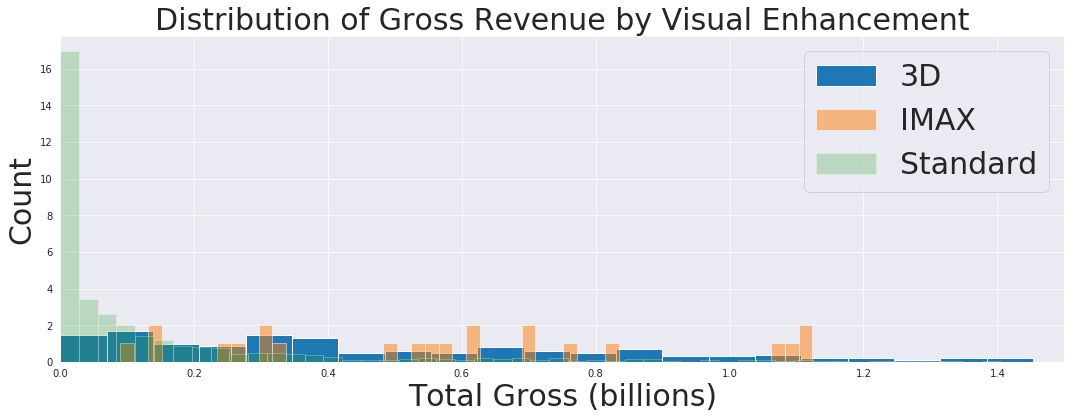

In [111]:
def plot_visually_enhanced_revenue_distribution():
    """
    plots the distribution of gross revenue for 3D, IMAX, and Standard definition films.
    """

    f = plt.figure(figsize=(18, 6))

    sns.distplot(a=split_3d.groupby('primary_title').sum().total_gross, bins=50, hist=True, hist_kws=dict(alpha=1), kde_kws=dict(alpha=0))
    sns.distplot(a=imax.total_gross, bins=50, kde=False, hist_kws=dict(alpha=0.5), kde_kws=dict(alpha=0))
    sns.distplot(a=final_df.total_gross, bins=50, hist_kws=dict(alpha=0.25), kde_kws=dict(alpha=0))
    
    plt.legend(['3D', 'IMAX', "Standard"], fontsize=30)

    plt.xlabel("Total Gross (billions)", fontsize=30)
    plt.ylabel('Count', fontsize=30)
    plt.title("Distribution of Gross Revenue by Visual Enhancement", fontsize=30)
    plt.xlim([0, 1.5])
    plt.show()
    
plot_visually_enhanced_revenue_distribution()

#### Analysis: 

As can be seen in this chart, the distribution of the earning potential of 3D and IMAX movies tends to be greater than those movies without some enhanced visual element.  

Because Microsoft has access to high end, proprietary media and interactive hardware (Hololense, Xbox Kinect, etc.), they could provide more immersive viewing experiences for their viewers by integrating these technologies. The popularity and earning potential of 3D and IMAX films may suggest that these enhanced visuals may help to increase the viewer bass and total gross revenue. 